In [1]:
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt

The following code until the histogram is incredibly similar to the tutorial however, I did increase the detection threshhold from 1.5 sigma to 5. I did this because there was a lot of excess noise in the image, so this decreased that.

In [2]:
h = fits.open(r"C:\Users\jacks\Downloads\hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = h[0].data.astype(np.float64)


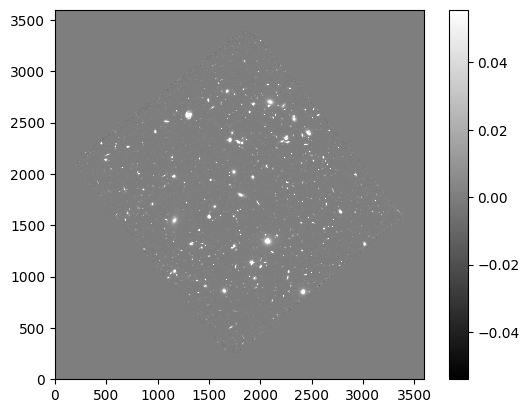

In [3]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig("2fig1.png", dpi=150)
plt.show()

In [4]:
bkg = sep.Background(data)

In [5]:
bkg_image = bkg.back()

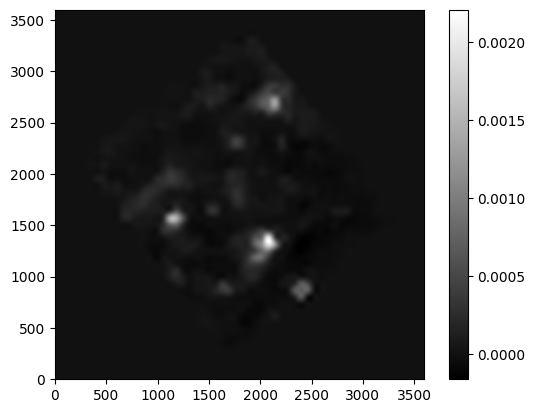

In [6]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig("2fig2.png", dpi=150)
plt.show()

In [7]:
bkg_rms = bkg.rms()

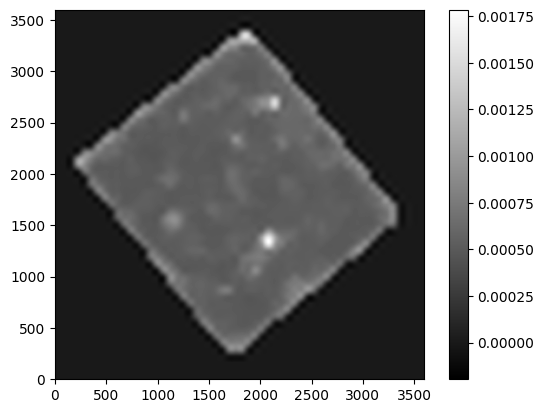

In [8]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig("2fig3.png", dpi=150)
plt.show()

In [9]:
data_sub = data - bkg

In [10]:
objects = sep.extract(data_sub, 5, err=bkg.globalrms)
print("Number of objects found:", len(objects))

Number of objects found: 2633


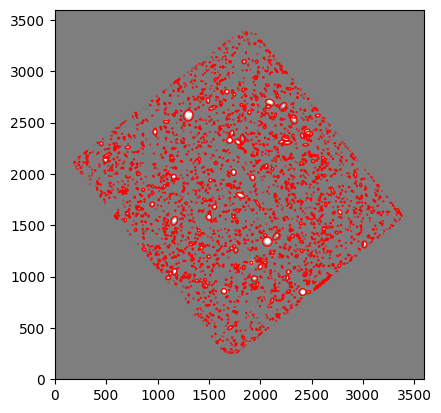

In [11]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("2fig4.png", dpi=150)
plt.show()

This cell creates a histogram of the log of the fluxes. I chose this since there was a very large distribution of incredibly large and incredibly small flux ratings, so showing the objects with the log of their flux value made all of the numbers more visible.

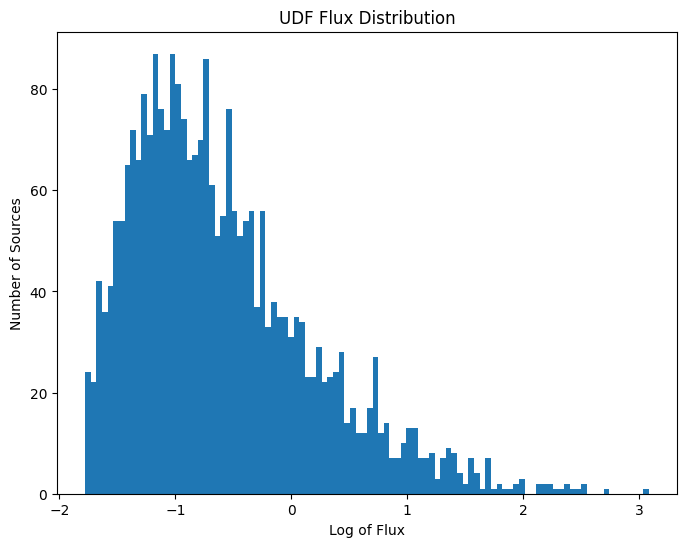

In [12]:
fluxes = objects['flux']

plt.figure(figsize=(8,6))
plt.hist(np.log10(fluxes), bins=100)
plt.xlabel("Log of Flux")
plt.ylabel("Number of Sources")
plt.title("UDF Flux Distribution")
plt.savefig("udf_flux_hist.png", dpi=150)
plt.show()


The next two cells calculate and print the the information from the dataset. The median flux is incredibly low, even compared to the mean, showing that there are massive outliers in this dataset. The largest object has a flux value or 1212.513 and it is located in the bottom middle of the image. Additionally, the object is 38.76 standard deviations from the mean.

In [13]:
mean = np.mean(fluxes)
median = np.median(fluxes)
std = np.std(fluxes)

print("Mean flux:", mean)
print("Median flux:", median)
print("Std dev:", std)


Mean flux: 3.57481736701054
Median flux: 0.17662547528743744
Std dev: 31.185972408734166


In [14]:
max_flux = np.max(fluxes)
max_index = np.argmax(fluxes)
max_obj = objects[max_index]

sigma_offset = (max_flux - mean) / std

print("Largest flux:", max_flux)
print("Coordinates (x, y):", max_obj['x'], max_obj['y'])
print("Number of sigma from mean:", sigma_offset)


Largest flux: 1212.5137939453125
Coordinates (x, y): 1914.2791323778993 1134.3190597343826
Number of sigma from mean: 38.76547316638162


The next few cells deal with the three color rgb image. I had to use a different command instead of the newbyteorder since it wasn't working for me. 

In [15]:
f105 = fits.getdata(r"C:\Users\jacks\Downloads\hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
f125 = fits.getdata(r"C:\Users\jacks\Downloads\hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
f160 = fits.getdata(r"C:\Users\jacks\Downloads\hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")

median_f105 = np.nanmedian(f105[f105<1])
median_f125 = np.nanmedian(f125[f125<1])
median_f160= np.nanmedian(f160[f160<1])
print(f'Median of f105 sky {median_f105}')
print(f'Median of f125 sky {median_f125}')
print(f'Median of f160 sky {median_f160}')

Median of f105 sky 0.0
Median of f125 sky 0.0
Median of f160 sky 0.0


In [16]:
f105 = f105.astype(f105.dtype.newbyteorder('='))
f125 = f125.astype(f125.dtype.newbyteorder('='))
f160 = f160.astype(f160.dtype.newbyteorder('='))

In [17]:
bkg_f105 = sep.Background(f105)
bkg_f125 = sep.Background(f125)
bkg_f160 = sep.Background(f160)

f105 -= bkg_f105
f125 -= bkg_f125
f160 -= bkg_f160


In [18]:
median_f105 = np.nanmedian(f105[f105<1])
median_f125 = np.nanmedian(f125[f125<1])
median_f105 = np.nanmedian(f160[f160<1])
print(f'Median of f105 sky {median_f105}')
print(f'Median of f125 sky {median_f125}')
print(f'Median of f160 sky {median_f160}')

Median of f105 sky 2.268324725663603e-21
Median of f125 sky 7.127440320205985e-22
Median of f160 sky 0.0


Here, I decreased the minimum and maximum of the data since many of the dimmer objects were not shown in the image since their value was much smaller than the previous minimum.

In [19]:
def rescale_data(data,dmin=0.0001,dmax=1.0) :

    datac = np.clip(data,dmin,dmax)
    return (np.log10(datac)-np.log10(dmin))/(np.log10(dmax)-np.log10(dmin))

In [20]:
p_f105 = rescale_data(f105)
p_f125 = rescale_data(f125)
p_f160 = rescale_data(f160)

In [21]:
rgb = np.stack([p_f160,0.7*p_f125,p_f105,],axis=-1)
print(rgb.shape)

(3600, 3600, 3)


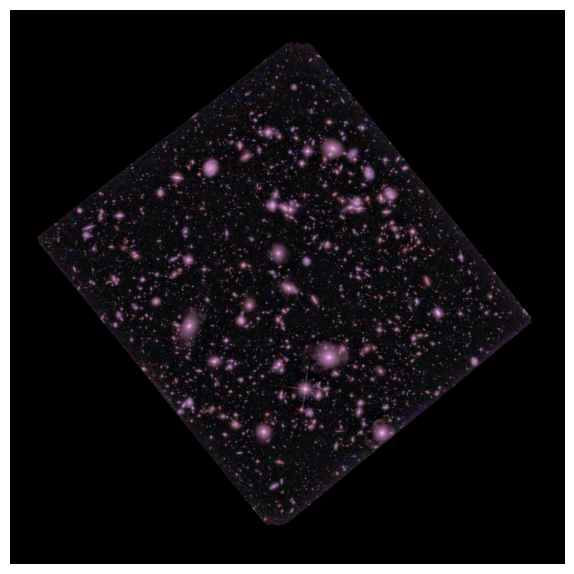

In [22]:
xsize= rgb.shape[1]
ysize= rgb.shape[0]

f,ax = plt.subplots(1,1,figsize=(xsize/500.,ysize/500.0))
ax.axis('off')
ax.imshow(rgb,origin='lower')

plt.savefig("udf_rgb.png", dpi=150)
plt.show()